In [1]:
pip install tensorboard --upgrade

Note: you may need to restart the kernel to use updated packages.
'C:\Users\Soundharya' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
import torch,torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
from torch.utils.tensorboard import SummaryWriter
import sys

ImportError: TensorBoard logging requires TensorBoard version 1.15 or above

In [9]:
Writer = SummaryWriter("runs/mnist2")

NameError: name 'SummaryWriter' is not defined

In [4]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
#hyper parameters
input_dim = 784
hidden_dim = 500
output_dim = 10
num_epochs = 5
batch_size = 64
learning_rate = 0.01

# LOADING DATASET

In [6]:
train_dataset = dsets.MNIST(root='./data',train=True,transform=transforms.ToTensor(),download=True)

test_dataset = dsets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download=True)

In [7]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

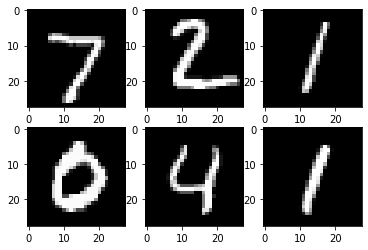

In [8]:
examples =iter(test_loader)
example_data,example_targets=examples.next()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i][0],cmap='gray')
#plt.show()
img_grid = torchvision.utils.make_grid(example_data)
Writer.add_image('mnist_images',img_grid)


# CREATE MODEL CLASS

In [9]:
class Feedforward_NN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Feedforward_NN, self).__init__()
        # Linear function 1: 784 --> 100
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()

        # Linear function 2: 100 --> 100
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.relu2 = nn.ReLU()

        # Linear function 3: 100 --> 100
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.relu3 = nn.ReLU()

        # Linear function 4 (readout): 100 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.relu2(out)

        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.relu3(out)

        # Linear function 4 (readout)
        out = self.fc4(out)
        #no activation and no softmax at end
        return out

# INSTANTIATE MODEL CLASS

In [10]:
model = Feedforward_NN(input_dim, hidden_dim, output_dim).to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

In [11]:
criterion = nn.CrossEntropyLoss()



optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
Writer.add_graph(model, example_data.reshape(-1,784).to(device))
Writer.close()
#sys.exit()

# TRAIN THE MODEL

In [13]:
n_tsteps = len(train_loader)
running_loss =0.0
running_correct= 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Load images with gradient accumulation capabilities
        images = images.reshape(-1, 784).to(device)
        labels = labels.to(device)

        # Forward pass to get output/logits
        outputs = model(images)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        running_loss+=loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_correct += (predicted == labels).sum().item()

        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_tsteps}],Loss: {loss.item():.4f}')
            Writer.add_scalar('training_loss',running_loss/100,epoch*n_tsteps+i)
            Writer.add_scalar('accuracy',running_correct/100,epoch*n_tsteps+i)
            running_loss=0.0
            running_correct=0
        

Epoch [1/5], Step [100/938],Loss: 2.2929
Epoch [1/5], Step [200/938],Loss: 2.2786
Epoch [1/5], Step [300/938],Loss: 2.2723
Epoch [1/5], Step [400/938],Loss: 2.2593
Epoch [1/5], Step [500/938],Loss: 2.2315
Epoch [1/5], Step [600/938],Loss: 2.1729
Epoch [1/5], Step [700/938],Loss: 2.1027
Epoch [1/5], Step [800/938],Loss: 1.9340
Epoch [1/5], Step [900/938],Loss: 1.6964
Epoch [2/5], Step [100/938],Loss: 1.1465
Epoch [2/5], Step [200/938],Loss: 0.8801
Epoch [2/5], Step [300/938],Loss: 0.7161
Epoch [2/5], Step [400/938],Loss: 0.8530
Epoch [2/5], Step [500/938],Loss: 0.7364
Epoch [2/5], Step [600/938],Loss: 0.6524
Epoch [2/5], Step [700/938],Loss: 0.5585
Epoch [2/5], Step [800/938],Loss: 0.6557
Epoch [2/5], Step [900/938],Loss: 0.4906
Epoch [3/5], Step [100/938],Loss: 0.4910
Epoch [3/5], Step [200/938],Loss: 0.3093
Epoch [3/5], Step [300/938],Loss: 0.2540
Epoch [3/5], Step [400/938],Loss: 0.3120
Epoch [3/5], Step [500/938],Loss: 0.5041
Epoch [3/5], Step [600/938],Loss: 0.4093
Epoch [3/5], Ste

# TEST THE MODEL

In [14]:
labels=[]
preds=[]

with torch.no_grad():
    # Calculate Accuracy         
    correct = 0
    total = 0

    # Iterate through test dataset
    for images, labels1 in test_loader:
        # Load images with gradient accumulation capabilities
        images = images.reshape(-1, 784).to(device)
        labels1 = labels1.to(device)

        # Forward pass only to get logits/output
        outputs = model(images)

        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)

        # Total number of labels
        total += labels1.size(0)

        # Total correct predictions
        correct += (predicted == labels1).sum()

        class_pred = [F.softmax(output,dim =0) for output in outputs]
        preds.append(class_pred)
        labels.append(predicted)
    
    preds = torch.cat([torch.stack(batch) for batch in preds])
    labels = torch.cat(labels)
    accuracy = 100 * correct / total

    # Print Loss
    print(f'Accuracy of the network on the test images: {accuracy}%')

    for i in range(10):
        labels_i= labels == i
        preds_i= preds[:,1]
        Writer.add_pr_curve(str(i),labels_i,preds_i,global_step=0)
        Writer.close()

Accuracy of the network on the test images: 91.20999908447266%
